### This notebook is an **excercise** in ###
    
    
*  using Jupyter Notebook,
*  data wrangling, i.e. data cleaning & processing in various ways,
*  [analyzing data to get some insights](#id1),
*  [building a linear regression model](#id2),
*  using a real dataset and diffrent Python libraries/modules,

  **all done by an aspiring data hobbyist :)**
  
  The dataset is from [Avoindata.fi](https://www.avoindata.fi/data/fi/dataset/ajoneuvojen-avoin-data ) and contains approximately 5,1 million rows of data
  
  
  
   
        


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import linear_model
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# without low memory=False gives a warning 
df = pd.read_csv('./open_data/TieliikenneAvoinData_5_13.csv', delimiter=';', low_memory=False) 

### First peek at the data frame

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5121147 entries, 0 to 5121146
Data columns (total 38 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   ajoneuvoluokka             object 
 1   ensirekisterointipvm       object 
 2   ajoneuvoryhma              float64
 3   ajoneuvonkaytto            float64
 4   variantti                  object 
 5   versio                     object 
 6   kayttoonottopvm            int64  
 7   vari                       object 
 8   ovienLukumaara             float64
 9   korityyppi                 object 
 10  ohjaamotyyppi              float64
 11  istumapaikkojenLkm         float64
 12  omamassa                   float64
 13  teknSuurSallKokmassa       float64
 14  tieliikSuurSallKokmassa    float64
 15  ajonKokPituus              float64
 16  ajonLeveys                 float64
 17  ajonKorkeus                float64
 18  kayttovoima                object 
 19  iskutilavuus               float64
 20  su

### Too many columns...

For this excercise, we won't need many of them, so let's get rid of some of them.


In [4]:
# Dropping some columns
df = df.drop(columns=['sahkohybridinluokka', 'ajoneuvoryhma', 'ovienLukumaara','ohjaamotyyppi','vaihteidenLkm', 
                      'vaihteisto', 'variantti', 'versio', 'korityyppi', 'tyyppihyvaksyntanro', 'valmistenumero2',
                      'sahkohybridi', 'ahdin', 'ohjaamotyyppi', 'istumapaikkojenLkm',
                      'omamassa', 'teknSuurSallKokmassa', 'tieliikSuurSallKokmassa', 'ajonKokPituus',
                      'ajonLeveys', 'ajonKorkeus', 'iskutilavuus', 'suurinNettoteho', 'sylintereidenLkm',
                      'mallimerkinta', 'voimanvalJaTehostamistapa', 'yksittaisKayttovoima', 'Co2', 'jarnro',
                      'kaupallinenNimi'])

In [5]:
# That's better selection of columns for this small excercise.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5121147 entries, 0 to 5121146
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ajoneuvoluokka        object 
 1   ensirekisterointipvm  object 
 2   ajoneuvonkaytto       float64
 3   kayttoonottopvm       int64  
 4   vari                  object 
 5   kayttovoima           object 
 6   merkkiSelvakielinen   object 
 7   kunta                 float64
 8   matkamittarilukema    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 351.6+ MB


### First look at the data in data frame

In [6]:
df.head()

,ajoneuvoluokka,ensirekisterointipvm,ajoneuvonkaytto,kayttoonottopvm,vari,kayttovoima,merkkiSelvakielinen,kunta,matkamittarilukema
0,MUU,NaN,1.0,19670000,NaN,01,BMW,91.0,NaN
1,MUU,1976-09-01,1.0,19760000,NaN,NaN,Sprite,475.0,NaN
2,M1,1984-07-09,1.0,19840000,1,01,Ford,179.0,NaN
3,MUU,1983-09-22,1.0,19830000,NaN,NaN,Omavalmiste,734.0,NaN
4,O1,1994-02-09,1.0,19940209,NaN,NaN,Valtteri,761.0,NaN


### 'Dirt' in Data

The first issue with the dataset is that some columns have unexpected datatypes, e.g. integers or strings. For example, notice that in columns **'kayttoonottopvm'** and **'ensirekisterointipvm'** there are values such as **NaN**, **19670000**, **1901** etc.. All these will cause erros if you try convert them into datetime using Pandas' built-in functions.

Therefore, some conversions need to be done.  

In [7]:
# Let's sort and see what we have in column 'kayttoonottopvm'
df.kayttoonottopvm.sort_values()

2488753           0
844939            0
1630877           0
8407              0
1977979           0
             ...   
5070887    20201231
5116148    20201231
5117183    20201231
5100619    20210104
5109422    20210104
Name: kayttoonottopvm, Length: 5121147, dtype: int64

### Zeros need to be converted 
As you can see in the above output, there are many 0 values which won't convert to a datetime. Let's replace the 0s with 19500101, which will convert nicely to a date. Alternatively, we could simply ditch the zeros from the data set. 


In [8]:
df['kayttoonottopvm'].replace(0, 19500101, inplace = True)

In [9]:
# Then we convert dtype to string so we can further 'massage' the values with regex 
df.kayttoonottopvm = df.kayttoonottopvm.astype(str)

In [10]:
df.kayttoonottopvm

0          19670000
1          19760000
2          19840000
3          19830000
4          19940209
             ...   
5121142    20201231
5121143    20150814
5121144    20201231
5121145    20201231
5121146    20190927
Name: kayttoonottopvm, Length: 5121147, dtype: object

### Four zeros will spell troubles...
...when trying to convert e.g. 19670000 to a datetime. See a fix to this below. 

In [11]:
# This regex will find exactly four zeros at the end of the string, 
# then replace the zeros with '0101' 
df.kayttoonottopvm.replace('[0]{4}$', '0101', regex=True, inplace=True)

In [12]:
# Let's verify the result is what we expect it to be
df.kayttoonottopvm.sort_values()

3000083    19000101
1471257    19020101
4826680    19030101
1359472    19040101
806027     19050101
             ...   
5070887    20201231
5116148    20201231
5117183    20201231
5100619    20210104
5109422    20210104
Name: kayttoonottopvm, Length: 5121147, dtype: object

In [13]:
# Then we change the data type to datetime  
#df['kayttoonottopvm'] = pd.to_datetime(df['kayttoonottopvm'], format='%Y%m%d', exact=False, dayfirst=True)
df['kayttoonottopvm'] = pd.to_datetime(df['kayttoonottopvm'], format='%Y%m%d')
#df['kayttoonottopvm'] = pd.to_datetime(df['kayttoonottopvm'], format='%d/%m/%Y %H:%M')
df['ensirekisterointipvm'] = pd.to_datetime(df['ensirekisterointipvm'], format='%Y-%m-%d')


### Another look at the *'ensirekisterointipvm'* and *'kayttoonottopvm'* columns

Let's take a peak at what the info() tells us now that we've applied some functions to these columns.

As you see, for columns *'ensirekisterointipvm'* and *'kayttoonottopvm'*,  
the datatype has turned into datetime, wunderbar!


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5121147 entries, 0 to 5121146
Data columns (total 9 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ajoneuvoluokka        object        
 1   ensirekisterointipvm  datetime64[ns]
 2   ajoneuvonkaytto       float64       
 3   kayttoonottopvm       datetime64[ns]
 4   vari                  object        
 5   kayttovoima           object        
 6   merkkiSelvakielinen   object        
 7   kunta                 float64       
 8   matkamittarilukema    float64       
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 351.6+ MB


### Narrowing further the type of vehicles included in the data frame

In [15]:
# We include into the data set only cars
anllist = ['M1', 'M1G']
df['ajoneuvoluokka'] = df[df['ajoneuvoluokka'].isin(anllist)]

In [16]:
df = df[df['ajoneuvoluokka'].notna()]

In [17]:
df.ajoneuvoluokka.isnull().sum()

0

In [18]:
df.ajoneuvoluokka.value_counts()

M1     2636909
M1G      97082
Name: ajoneuvoluokka, dtype: int64

<a id='id1'></a>
### Let's prepare some color data for further analysis... ###

...and we start with <span style="color:orange">co</span><span style="color:green">lo</span><span style="color:brown">rs</span>.


In [19]:
# Looking at the vehicle color data, we see that further data cleaning needs to be done 
# so that the data turns friendly to our eyes.
df['vari'].value_counts(ascending=True)

X      1340
Z      3374
3     11614
7     12498
4     24215
5    121240
1    200534
Y    216296
9    366457
6    374690
2    397847
0    398012
8    595033
Name: vari, dtype: int64

In [20]:
# Let's see how many nulls there are amongst color
df['vari'].isnull().sum()

10841

### 10k nulls in color data
Those without color data won't be included in the color analysis, but are still kept in the data frame.  

Next, I'm using regular Python inside the notebook to loop through the colors to count & assign each a human friendly label for later use in plots.


In [21]:
# Option: we replace nulls with 'none'. 
#df['vari'].fillna('none', inplace = True)    

In [22]:

colors = df['vari']
color_counter = Counter()
for color in colors:
    if color == '0':
        color_counter.update(['black'])
    elif color == '1':
        color_counter.update(['brown'])
    elif color == '2':
        color_counter.update(['red'])
    elif color == '3':
        color_counter.update(['orange'])
    elif color == '4':
        color_counter.update(['yellow'])
    elif color == '5':
        color_counter.update(['green'])
    elif color == '6':
        color_counter.update(['blue'])
    elif color == '7':
        color_counter.update(['violet'])
    elif color == '8':
        color_counter.update(['grey'])
    elif color == '9':
        color_counter.update(['white'])
    elif color == 'X':
        # multi-colored vehicles are given color label 'rainbow'
        color_counter.update(['rainbow'])
    elif color == 'Y':
        color_counter.update(['silver'])
    elif color == 'Z':
        color_counter.update(['turquoise'])
    # included in case nulls converted to none
    elif color == 'none':
        color_counter.update(['none'])
        

color = []
color_count = []

# colors
# to get the least common, use --> for item in color_counter.most_common(10)[:-10:-1]:
#
for item in color_counter.most_common(10):
    color.append(item[0])
    color_count.append(item[1])
    
color.reverse()
color_count.reverse()

        


In [23]:
# Here we verify that our looping/counting operations above 
# has produced the results expected for colors.
color

['violet',
 'yellow',
 'green',
 'brown',
 'silver',
 'white',
 'blue',
 'red',
 'black',
 'grey']

In [24]:
# And counts top 10 sorted ascending here ascending here 
color_count

[12498, 24215, 121240, 200534, 216296, 366457, 374690, 397847, 398012, 595033]

### First plot - horizontal bar chat

Text(0.5, 0, 'henkilöautojen määrä/väri')

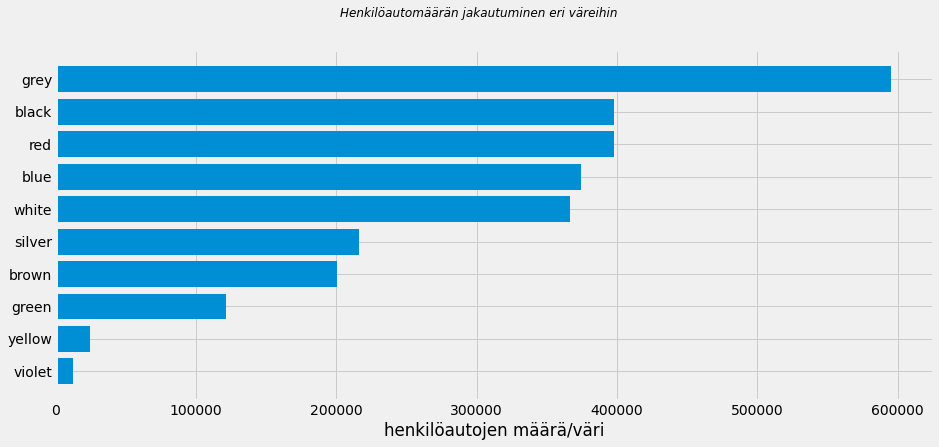

In [25]:
# You can experiment how different plot styles display the same data  
#plt.style.use("ggplot")
plt.style.use("fivethirtyeight")
# for xkcd comic style use the below line
#plt.xkcd()

fig, ax1 = plt.subplots(1, figsize=(14, 6))
fig.suptitle('Henkilöautomäärän jakautuminen eri väreihin', horizontalalignment='center', fontstyle='italic', 
             fontsize='12')
ax1.barh(color, color_count)
ax1.set_yticks(color)
ax1.set_xlabel('henkilöautojen määrä/väri')



### Grey scale colors by far the most popular in cars
This bar chart tells us clearly the favourite car colors in Finland, I wonder what makes these colors so popular?
***
### Let's look deeper into the colors and car brands

* If grey is the top color overall, will it be so for a given brand?
* Top five brands, what colors are most popular?
* Pick a color, what brand is most numerous in that color?
* What's the propability that a car is <code><span style="color:yellow">yellow</span></code> Kia?
* What's the propability that a car is <span style="color:green">green</span> Honda, and its most probable**  municipality of use is Heinola?

---
\*\*all vehicles in the data set are given "most propable municipality of use"


**Let's find out!**

In [26]:
# First shorten some brand names
df['merkkiSelvakielinen'].replace('Volkswagen', 'VW', inplace = True)
df['merkkiSelvakielinen'].replace('Mercedes-Benz', 'M-B', inplace = True)
df['merkkiSelvakielinen'].replace('Volkswagen, VW', 'VW', inplace = True)

In [27]:
# Color codes are converted into colors, we will use these later
df['vari'].replace('0', 'black', inplace = True)
df['vari'].replace('1', 'brown', inplace = True)
df['vari'].replace('2', 'red', inplace = True)
df['vari'].replace('3', 'orange', inplace = True)
df['vari'].replace('4', 'yellow', inplace = True)
df['vari'].replace('5', 'green', inplace = True)
df['vari'].replace('6', 'blue', inplace = True)
df['vari'].replace('7', 'violet', inplace = True)
df['vari'].replace('8', 'grey', inplace = True)
df['vari'].replace('9', 'white', inplace = True)
df['vari'].replace('X', 'rainbow', inplace = True)
df['vari'].replace('Y', 'silver', inplace = True)
df['vari'].replace('Z', 'turquoise', inplace = True)

You might wonder why I'm doing this again, as did assign color names to codes earlier, right? Correct, I did, but I didn't do it for the data in the data frame. I used the data in the data frame but created separate counters and variables and used those to create the first plot. 

### Top 5 car brands

In [28]:
# Top 5 car brands 
df.merkkiSelvakielinen.value_counts().head(5)

Toyota    373830
VW        300665
Volvo     237668
Ford      188361
M-B       183517
Name: merkkiSelvakielinen, dtype: int64

In [29]:
# Let's take the top 3 and compare colour popularity among each   
mlist = ['Toyota', 'VW', 'Volvo']
dg= df[df['merkkiSelvakielinen'].isin(mlist)]

In [30]:
#dg['vari'].value_counts(ascending=False)

Grey is the top color in amongst the top 3 most numerous vehicle brands, but interestingly for Toyota, it is the silver and red colors before grey. See how the top colors change with the other top 5 brands. 

<AxesSubplot:ylabel='vari,merkkiSelvakielinen'>

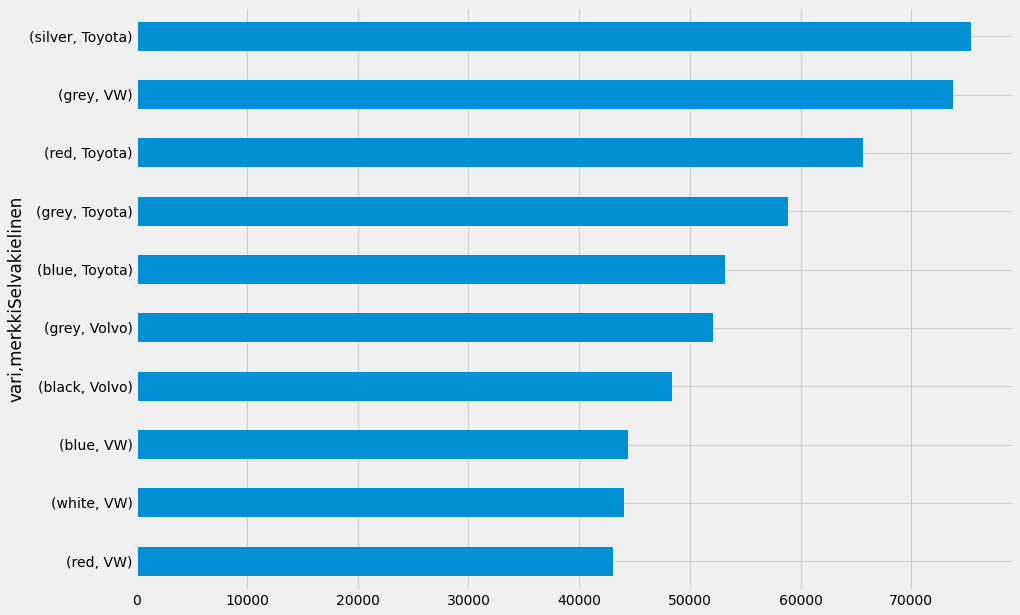

In [31]:
# Grouping the brands by color
dg.groupby('vari').merkkiSelvakielinen.value_counts().sort_values().tail(10).plot.barh(figsize=(14, 10))

In [32]:
# Compare color popularity among brands at positions 4 and 5 to peak holder Toyota    
mlist = ['Toyota', 'Ford', 'M-B']
dh= df[df['merkkiSelvakielinen'].isin(mlist)]

<AxesSubplot:ylabel='vari,merkkiSelvakielinen'>

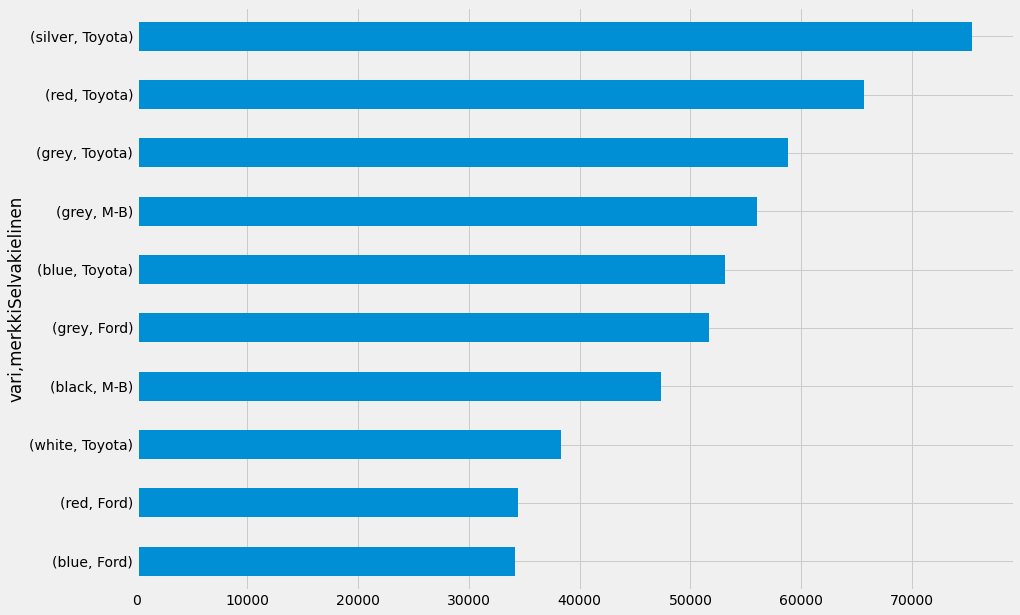

In [33]:
dh.groupby('vari').merkkiSelvakielinen.value_counts().sort_values().tail(10).plot.barh(figsize=(14, 10))

### Orange is one the least popular colour, which brands are most popular in orange?


In [34]:
# If you want to look at the color popularity for a given brand, 
# remove comment in this cell, first pick your color and run the cell, then uncomment the line below & run it.
# Then go to the barh cell and rerun it.
#dc = df.query('merkkiSelvakielinen == "Ferrari"') 
#dc['merkkiSelvakielinen'].value_counts()

In [35]:
# Change the color and run the plot again
#clist = ['grey']
clist = ['orange']
dc= df[df['vari'].isin(clist)]


<AxesSubplot:ylabel='vari,merkkiSelvakielinen'>

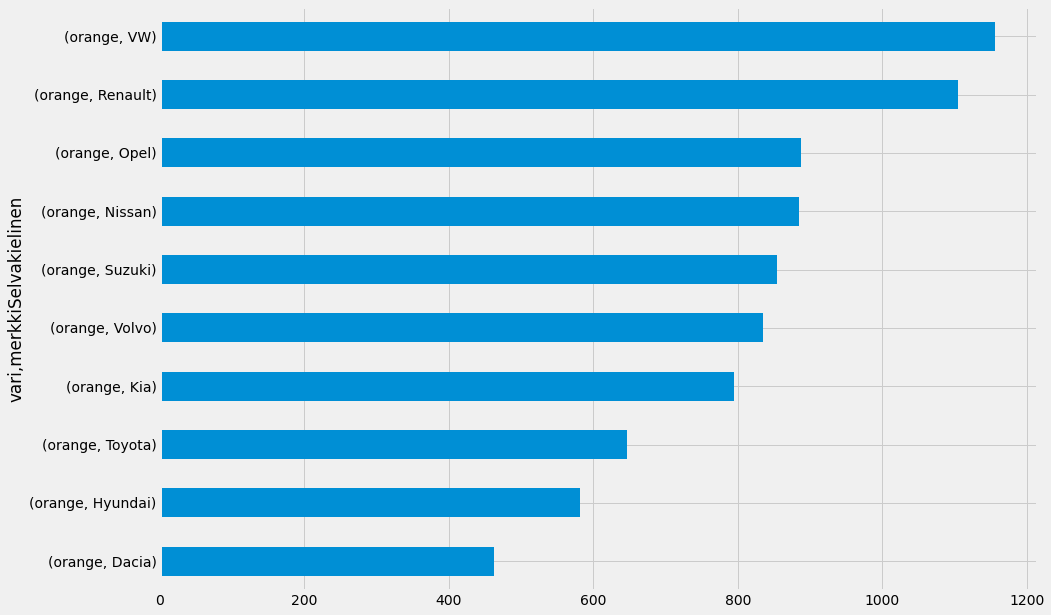

In [36]:
# 
dc.groupby('vari').merkkiSelvakielinen.value_counts().sort_values().tail(10).plot.barh(figsize=(14, 10))


### We see that different brands occupy the list when compared to e.g. grey

### So what's the propability that it's yellow Kia?
+ We're going to first create another data frame where we place all the data for just the Kia brand
+ We drop the nulls from the color column
+ Last, we count the propability for yellow Kia 

In [37]:
# First we look at the Kia population colours
dk = df.query('merkkiSelvakielinen == "Kia"')
dk = dk[dk['vari'].notna()]
dk.vari.value_counts().sum()

89155

In [38]:
# Verifying dk data frame contains what it should contain
dk.merkkiSelvakielinen.unique()

array(['Kia'], dtype=object)

In [39]:
# Calculate the proportion of Kia's from all car brands
Kia = df.merkkiSelvakielinen.value_counts().Kia.sum()/df.merkkiSelvakielinen.value_counts().sum()
Kia

0.03262436406557646

In [40]:
# Calculate the proportion of yellow from all Kia brand colours
# and the propability for yellow Kia
kelt = dk.vari.value_counts().yellow.sum()/dk.vari.value_counts().sum()
kelt
ykia = Kia*kelt
ykia

0.0003640989540154627

In [41]:
print("Propability of a yellow Kia is {:.3f}%.\nNot a very high propability to spot a yellow Kia amongst the cars.".format(ykia*100))



Propability of a yellow Kia is 0.036%.
Not a very high propability to spot a yellow Kia amongst the cars.


### Propability of a yellow Kia is 0.036%
+ What conclusions can we draw from the popularity of the colors?
+ We can say that warmer colors are not so popular, see the top 5 colors pie char below.
+ Next time you spot a yellow Kia, you can think it was a fairly rare spotting.
 

### Top 5 colors as pie chart

<AxesSubplot:ylabel='vari'>

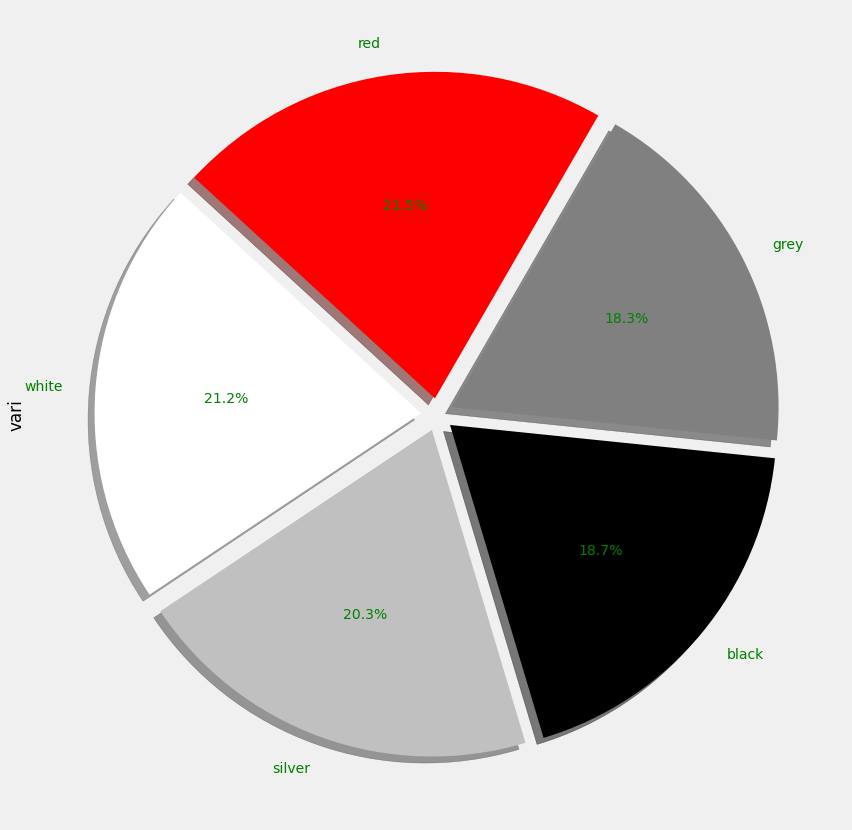

In [42]:
# Drawing the pie

explode = (0.05, 0.05, 0.05, 0.05, 0.05)
pie_colors = ['red','white', 'silver','black', 'grey']
dk.vari.value_counts().head(5).plot.pie(figsize=(14, 14),explode=explode, colors=pie_colors, autopct='%1.1f%%',
        shadow=True, startangle=60, textprops=dict(color="green"))  

### Top 10 car brands as bar chart

<AxesSubplot:>

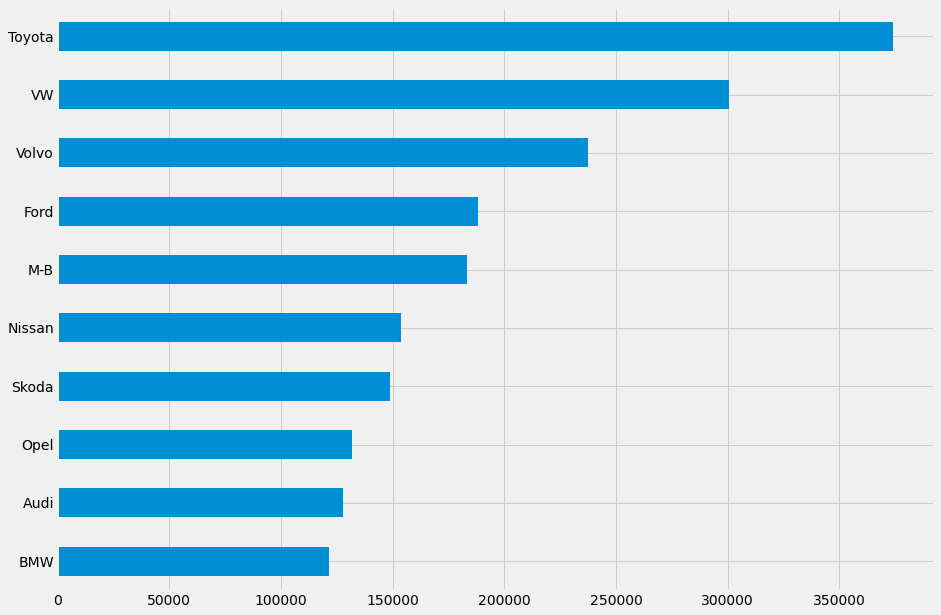

In [43]:
#df.merkkiSelvakielinen.value_counts().head(50)
df.merkkiSelvakielinen.value_counts().sort_values().tail(10).plot.barh(figsize=(14, 10))


### And what about that green Honda with most propable place of use in Heinola?

In [44]:
# First narrowing the municipality to Heinola
df['kunta'] = df.kunta.astype(str)
df['kunta'].replace('111.0', 'Heinola', inplace = True)
dj = df.query('kunta == "Heinola"')
dj.kunta.unique()
#dj.kunta.value_counts().sum()

array(['Heinola'], dtype=object)

In [45]:
# Checking the dj data frame info 
dj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9965 entries, 1041 to 5120678
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ajoneuvoluokka        9965 non-null   object        
 1   ensirekisterointipvm  9939 non-null   datetime64[ns]
 2   ajoneuvonkaytto       9963 non-null   float64       
 3   kayttoonottopvm       9965 non-null   datetime64[ns]
 4   vari                  9935 non-null   object        
 5   kayttovoima           9965 non-null   object        
 6   merkkiSelvakielinen   9964 non-null   object        
 7   kunta                 9965 non-null   object        
 8   matkamittarilukema    8724 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 778.5+ KB


In [46]:
# How many Hondas with most propable place of use in Heinola?
dj.merkkiSelvakielinen.value_counts().Honda


204

<AxesSubplot:>

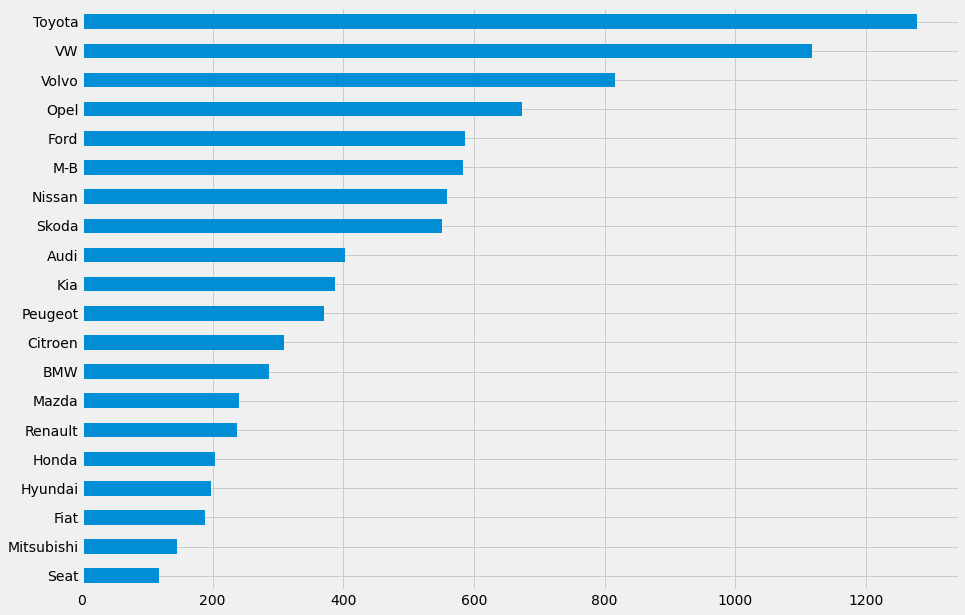

In [47]:
# Looking at the top 20 brands with most propable place of use in Heinola
dj.merkkiSelvakielinen.value_counts().sort_values().tail(20).plot.barh(figsize=(14, 10))

### Honda is not so popular in Heinola
* 204 Hondas vs. well over 1200 Toyotas, I wonder will we find a green Honda among the 204? 
* First, let's see how many green cars in total with propable place of use in Heinola?

In [48]:
dj.vari.value_counts().green.sum()


510

<AxesSubplot:ylabel='vari,merkkiSelvakielinen'>

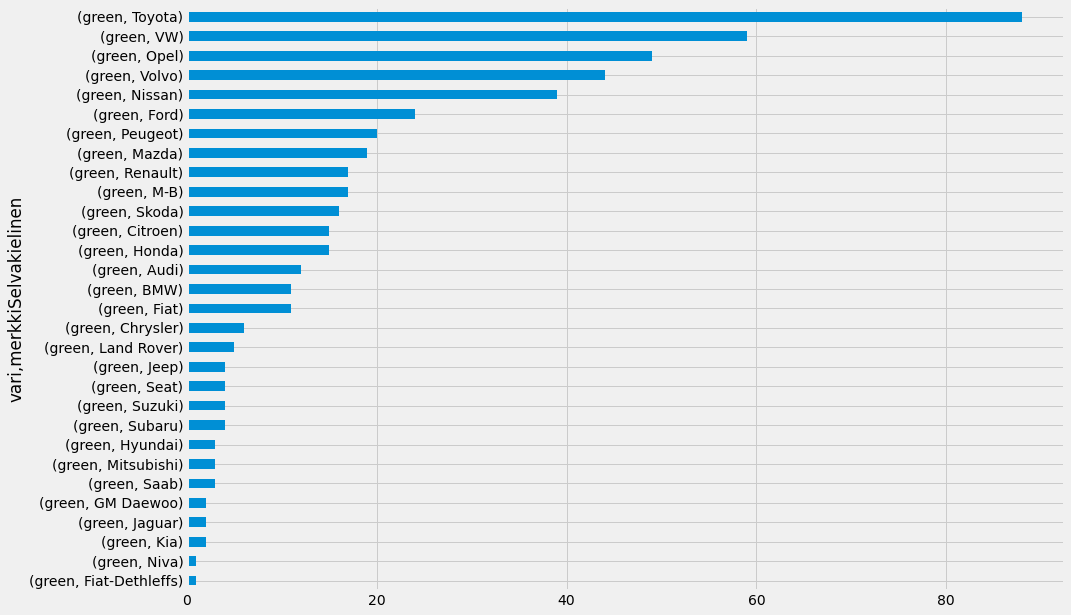

In [49]:
# Filter green cars 
clist = ['green']
di= dj[dj['vari'].isin(clist)]
di.groupby('vari').merkkiSelvakielinen.value_counts().sort_values().tail(30).plot.barh(figsize=(14, 10))


In [50]:
di.merkkiSelvakielinen.value_counts().Honda.sum()

15

Phew, at least there are some green Hondas, so we *can* calculate the propability...

### Rare vehicles are more present than we might think, you just need to formulate the question correctly...


In [51]:
# Propability of Honda with propable place of use in Heinola
Honda = dj.merkkiSelvakielinen.value_counts().Honda.sum()/df.merkkiSelvakielinen.value_counts().sum()
Honda

print("Propability of a Honda with propable place of use in Heinola is {:.4f}%.\n Add green color to make it exceedingly rare.".format(Honda*100))

Propability of a Honda with propable place of use in Heinola is 0.0075%.
 Add green color to make it exceedingly rare.


In [52]:
di.merkkiSelvakielinen.value_counts().Honda.sum()

15

In [53]:
vihr = di.merkkiSelvakielinen.value_counts().Honda.sum()/df.vari.value_counts().sum()
vihr
print("Propability of a green Honda with propable place of use in Heinola is {:.4f}%.\nIndeed, very unlikely that a green Honda you see has propable place of use in Heinola".format(vihr*100))


Propability of a green Honda with propable place of use in Heinola is 0.0006%.
Indeed, very unlikely that a green Honda you see has propable place of use in Heinola


### On with the show and towards predictions...

In [54]:
# include only petrol cars in this subset, diesels, electric and hybrids are excluded 
df = df.query('kayttovoima == "01"')

In [55]:
df.kayttovoima.isnull().sum()

0

In [56]:
# further limiting the use of the car to only cars in private use
df = df[df['ajoneuvonkaytto'] == 1]

In [57]:
df = df[df['ensirekisterointipvm'].notna()]

In [58]:
df = df[df['matkamittarilukema'].notna()]

In [59]:
# validating the data in certain columns doesn't contain nulls 
#df.ajoneuvonkaytto.unique()
#df.ajoneuvonkaytto.isnull().sum()
#df.ensirekisterointipvm.isnull().sum()
#df.matkamittarilukema.isnull().sum()

In [60]:
# creating new columns from existing data by extracting the year from date values
df['rekv'] = pd.DatetimeIndex(df['ensirekisterointipvm']).year


In [61]:
# years in the dataset
df.rekv.unique()

array([2003, 2006, 1996, 2000, 2005, 2001, 1998, 1999, 1993, 2008, 2002,
       1995, 1997, 2004, 1989, 1975, 1994, 2007, 1990, 1986, 1982, 1985,
       1987, 1991, 1988, 1992, 1981, 1984, 1977, 2009, 1976, 1980, 1978,
       1979, 1983, 2010, 2020, 2015, 2019, 2014, 2012, 2011, 2013, 2016,
       2017, 2018, 1967])

In [62]:
df.rekv = df.rekv.astype(int)

In [63]:
# narrowing the dataset to include only > year 
df = df[df['rekv']> 1999]

In [64]:
#df.rekv.value_counts()

In [65]:
#df.rekv.sort_values(ascending=False)

In [66]:
df['kms'] = df['matkamittarilukema']

In [67]:
df.kms.count()

1426748

In [68]:
df.kms = df.kms.astype(int)

In [69]:
df.kms.value_counts()

0         361
299999     35
12         35
15         34
14         33
         ... 
408477      1
406428      1
441229      1
270657      1
236090      1
Name: kms, Length: 365475, dtype: int64

In [70]:
# only cars driven between 1 and 400k km driven are included
df = df[df['kms'].between(1, 400000)]

In [71]:
#df.kms.max()

In [72]:
#df.kms.value_counts()

12        35
299999    35
15        34
14        33
17        31
          ..
269278     1
386017     1
390115     1
371992     1
329055     1
Name: kms, Length: 347512, dtype: int64

In [73]:
df.kms.describe()

count    1.407206e+06
mean     1.567414e+05
std      8.993975e+04
min      1.000000e+00
25%      8.096400e+04
50%      1.477270e+05
75%      2.219420e+05
max      4.000000e+05
Name: kms, dtype: float64

In [74]:
df.groupby(df['rekv'] == 2019).kms.describe()

,count,mean,std,min,25%,50%,75%,max
rekv,,,,,,,,
False,1388903.0,157499.77390,89921.254956,1.0,81695.0,148691.0,222786.0,400000.0
True,18303.0,99195.15522,70615.817657,2.0,42632.5,86374.0,146160.5,395033.0


The above descriptive statistics tell us that of all the cars in the data frame, some 67 000 were first registered in 2019, and already (the data set dates from late 2020) some have accumulated nearly 400 000 km in the odometer. That's a lot of driving for some! My guess is that someone has acquired a used taxi, which is then re-registered for private use.     

<a id='id2'></a>
### Building the linear regression model

* this is my first attempt to build one
* the assumption behind the model is that the older the first reg. year (rekv) , the more kilometers in the odometer. Conversely, the more recent the 1st registration date (year) is, the less kilometres in the odometer.
* The model will predict the odometer km, when given a year 


In [75]:
# assigning data 
x = df.rekv.iloc[:].values
y = df.kms.iloc[:].values
x = x.reshape(-1, 1)


In [76]:
# we split the data into training and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=0)

In [77]:
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

In [78]:
lm = linear_model.LinearRegression()
model = lm.fit(x_train,y_train)

In [79]:
model.coef_

array([-11446.37440007])

In [80]:
model.intercept_

23152512.818927757

In [81]:
# this is an estimate of how accurately the model predicts the odometer km when year is given
# if this value is one, it would be 'perfect', over one is overfitting.
model.score(x, y)

0.4625614899829983

### Predicting kilometres driven by a car first registered on 2019 

In [82]:
x_new = np.array([[2019]])
x_new.reshape(-1, 1)
y_pred = model.predict(x_new)

In [83]:
y_pred

array([42282.90518989])

### So, for a car registered in 2019, the model predicts it is ~ 40 000 km driven. Good enough :)

In [84]:
model.coef_*2019+model.intercept_

array([42282.90518989])

In [85]:
#df.plot(kind='scatter', x='rekv', y='kms', figsize=(14, 6))

In [86]:
#df[df['rekv']> 2019].plot(kind='scatter', x='rekv', y='kms', figsize=(14, 6))

 In this case, these two plots above are not so helpful, I suspect it's because there are so much data.
 By narrowing the year, car brand and color, the plots might be more useful. 

### Conclusions

This excercise was just a scratch on the surface, yet fun and reveals in practice how 
* powerful & useable [Python](https://www.python.org/about/) is, espcially when used via [Anaconda Data Science Platform](https://www.anaconda.com/),
* car buyers in Finland favor dull colors :), warm colors are rare.

**Thanks for Reading!**

